## Simulate and fit DCE-MRI

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from sepal import dce_fit, relaxivity, signal_models, water_ex_models, aifs, pk_models
%load_ext autoreload
%autoreload 2

### Simulate and fit time-concentration data

CPU times: total: 31.2 ms
Wall time: 31.4 ms
parameter: value (ground truth)
vp: 0.02007 (0.02000)
ps: 0.04962 (0.05000)
ve: 0.20519 (0.20000)
fp: 48.11957 (50.00000)
delay: 4.96790 (5.00000)


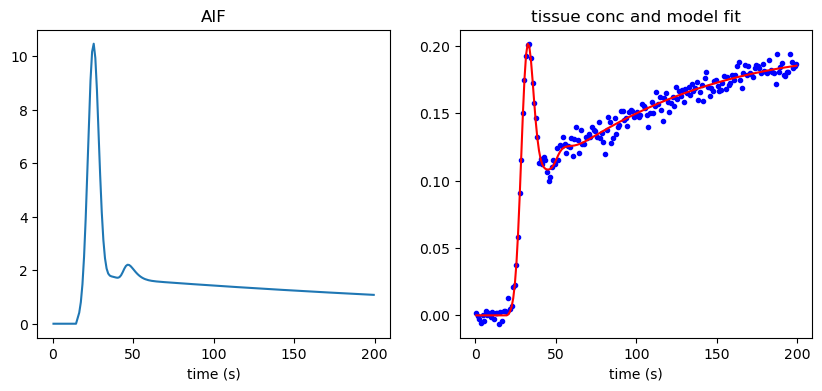

In [2]:
# define experiment timepoints
dt = 1.
t = np.arange(0,200)*dt + dt/2

# define ground-truth AIF, pharmacokinetic model, parameters and noise level
AIF = aifs.Parker(hct=0.42, t_start=15.)
pk_pars_ground_truth = {'vp': 0.02, 'ps': 5e-2, 've': 0.2, 'fp': 50, 'delay': 5}
pk_model_ground_truth = pk_models.TCXM(t, AIF, fixed_delay=None)
noise = 0.005

# generate "measured" concentration then add noise
C_t, _c_cp, _c_e = pk_model_ground_truth.conc(**pk_pars_ground_truth)
C_t += np.random.normal(loc = 0., scale = noise, size = C_t.shape)

# define AIF, pharmacokinetic model and starting parameters used for fitting.
PkModel = pk_models.TCXM(t, AIF, fixed_delay=None) # use ground-truth AIF to fit data, i.e. assume AIF is known accurately
pk_pars_0 = [{'vp': 0.005, 'ps': 1e-4, 've': 0.5, 'fp': 5, 'delay': 0}, 
             #{'vp': 0.1, 'ps': 1e-4, 've': 0.02, 'fp': 50, 'delay': 0}  # optionally specify multiple sets of starting values to find global minimum 
            ]
%time vp_fit, ps_fit, ve_fit, fp_fit, delay_fit, C_t_fit = dce_fit.ConcToPKP(PkModel, pk_pars_0).proc(C_t)

print("parameter: value (ground truth)")
print(f"vp: {vp_fit:.5f} ({pk_pars_ground_truth['vp']:.5f})")
print(f"ps: {ps_fit:.5f} ({pk_pars_ground_truth['ps']:.5f})")
print(f"ve: {ve_fit:.5f} ({pk_pars_ground_truth['ve']:.5f})")
print(f"fp: {fp_fit:.5f} ({pk_pars_ground_truth['fp']:.5f})")
print(f"delay: {delay_fit:.5f} ({pk_pars_ground_truth['delay']:.5f})")

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(t, AIF.c_ap(t));
ax[0].set_xlabel('time (s)');
ax[0].set_title('AIF');
ax[1].plot(t, C_t, 'b.', t, C_t_fit, 'r-');
ax[1].set_xlabel('time (s)');
ax[1].set_title('tissue conc and model fit');

### Simulate and fit in signal space

CPU times: total: 31.2 ms
Wall time: 37 ms
parameter: value (ground truth)
vp: 0.02253 (0.02000)
ps: 0.04741 (0.05000)
ve: 0.22285 (0.20000)
fp: 9.61862 (10.00000)
delay: 2.88814 (3.00000)


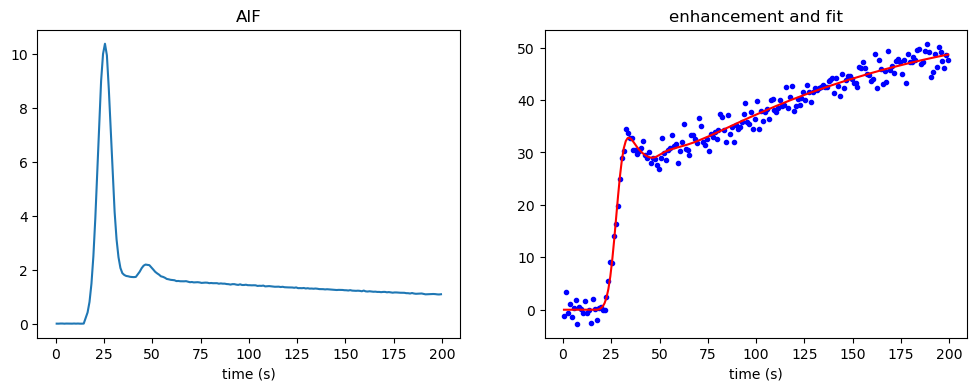

In [3]:
# define ground-truth (gt) properties
dt_gt = 0.1 # gt temporal resolution
AIF = aifs.Parker(hct=0.42, t_start=15.)
pk_pars_ground_truth = {'vp': 0.02, 'ps': 5e-2, 've': 0.2, 'fp': 10, 'delay': 3}
R10_tissue, R10_aif = 1./0.8, 1./1.7
hct = 0.42

# define acquisition properties
k_tissue, k_aif = 1.0, 1.0 # relative B1+ error
tr, fa, te = 4e-3, 15, 1.5e-3
dt = 1 # experimental temporal resolution
t = np.arange(0,round(200/dt))*dt + dt/2 # measured time points
noise = 1.5

# define ground-truth (gt) models for relaxivity, signal and pharmacokinetics
pk_model_gt = pk_models.TCXM(t, AIF, upsample_factor=round(dt/dt_gt), fixed_delay=None)
c_to_r_model_gt = relaxivity.CRLinear(r1=5.0, r2=7.1)
water_ex_model_gt = water_ex_models.FXL()
signal_model_gt = signal_models.SPGR(tr, fa, te)

# now generate the measured AIF 
c_ap = AIF.c_ap(t)
enh_aif = dce_fit.conc_to_enh(c_ap*(1-hct), 1/R10_aif, k_aif, c_to_r_model_gt, signal_model_gt)
enh_aif += np.random.normal(loc = 0., scale = noise, size = enh_aif.shape)
c_ap_meas = dce_fit.EnhToConc(c_to_r_model_gt, signal_model_gt).proc(enh_aif, 1/R10_aif, k_aif)/(1-hct)
aif_meas = aifs.PatientSpecific(t, c_ap_meas)

# generate the measured tissue enhancement
enh = dce_fit.pkp_to_enh(pk_pars_ground_truth, hct, k_tissue, 1/R10_tissue, 1/R10_aif, pk_model_gt, c_to_r_model_gt, water_ex_model_gt, signal_model_gt)
enh += np.random.normal(loc = 0., scale = noise, size = enh.shape)

# define models used for fitting
pk_model_fit = pk_models.TCXM(t, aif_meas, upsample_factor=3, fixed_delay=None)
c_to_r_model_fit = c_to_r_model_gt # use same model as for ground truth
water_ex_model_fit = water_ex_model_gt # use same model as for ground truth
signal_model_fit = signal_model_gt # use same model as for ground truth
k_tissue_fit = k_tissue # assume flip angle error is known accurately
pk_pars_0 = [{'vp': 0.005, 'ps': 1e-4, 've': 0.5, 'fp': 5, 'delay': 0},
             #{'vp': 0.1, 'ps': 1e-4, 've': 0.02, 'fp': 50, 'delay': 0}  # optionally specify multiple sets of starting values to find global minimum 
            ]

# fit the enhancement curve
%time vp_fit, ps_fit, ve_fit, fp_fit, delay_fit, enh_fit = dce_fit.EnhToPKP(enh, pk_model_fit, 1/R10_tissue, c_to_r_model_fit, water_ex_model_fit, signal_model_fit, pk_pars_0).proc(enh, k_tissue_fit, 1/R10_tissue)

print("parameter: value (ground truth)")
print(f"vp: {vp_fit:.5f} ({pk_pars_ground_truth['vp']:.5f})")
print(f"ps: {ps_fit:.5f} ({pk_pars_ground_truth['ps']:.5f})")
print(f"ve: {ve_fit:.5f} ({pk_pars_ground_truth['ve']:.5f})")
print(f"fp: {fp_fit:.5f} ({pk_pars_ground_truth['fp']:.5f})")
print(f"delay: {delay_fit:.5f} ({pk_pars_ground_truth['delay']:.5f})")

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(t, c_ap_meas);
ax[0].set_xlabel('time (s)');
ax[0].set_title('AIF');
ax[1].plot(t, enh, 'b.', t, enh_fit, 'r-')
ax[1].set_xlabel('time (s)');
ax[1].set_title('enhancement and fit');